# Cumulative distribution functions

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## The limits of PMFs

PMFs work well if the number of quantities is small.
But as the number of quantities increases, the probability associated with each quantity gets smaller and the effect of random noise increases.

For example, we might be interested in the distribution of birth weights.
In the NSFG data, the variable `totalwgt_lb` records weight at birth in pounds.
The following figure shows the PMF of these quantities for first babies and others.

In [4]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [5]:
import nsfg

live, firsts, others = nsfg.make_frames()

<IPython.core.display.Javascript object>

In [6]:
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()
print("Firsts", len(first_wgt), len(first_wgt_dropna))

Firsts 4413 4363


<IPython.core.display.Javascript object>

In [7]:
other_wgt = others.totalwgt_lb
other_wgt_dropna = other_wgt.dropna()
print("Others", len(other_wgt), len(other_wgt_dropna))

Others 4735 4675


<IPython.core.display.Javascript object>

In [8]:
from empiricaldist import Pmf

first_pmf = Pmf.from_seq(first_wgt_dropna, name="first")
other_pmf = Pmf.from_seq(other_wgt_dropna, name="other")

<IPython.core.display.Javascript object>

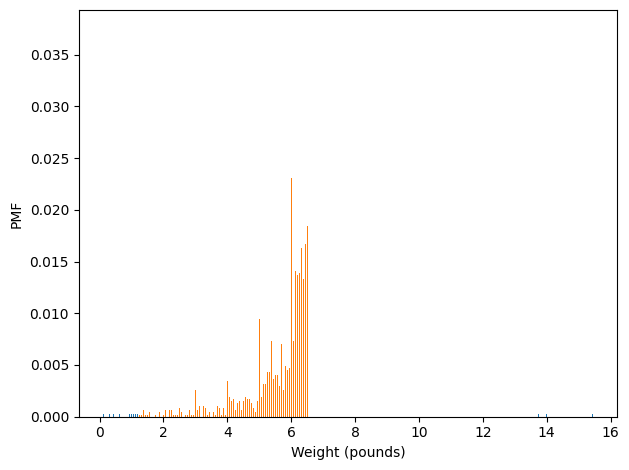

<IPython.core.display.Javascript object>

In [10]:
from thinkstats import two_bar_plots

two_bar_plots(first_pmf, other_pmf, width=0.01)
decorate(xlabel="Weight (pounds)", ylabel="PMF")

Overall, these distributions resemble the bell shape of a normal distribution, with many quantities near the mean and a few quantities much higher and lower.

But parts of this figure are hard to interpret.
There are many spikes and valleys, and some apparent differences between the distributions.
It is hard to tell which of these features are meaningful.
Also, it is hard to see overall patterns; for example, which distribution do you think has the higher mean?

These problems can be mitigated by binning the data; that is, dividing the range of quantities into non-overlapping intervals and counting the number of quantities in each bin.
Binning can be useful, but it is tricky to get the size of the bins right.
If they are big enough to smooth out noise, they might also smooth out useful information.

An alternative that avoids these problems is the cumulative distribution function (CDF), which is the subject of this chapter.
But before I can explain CDFs, I have to explain percentiles.

## Percentiles

If you have taken a standardized test, you probably got your results in the form of a raw score and a **percentile rank**.
In this context, the percentile rank is the fraction of people who scored lower than you (or the same).
So if you are "in the 90th percentile," you did as well as or better than 90% of the people who took the exam.

Here's how you could compute the percentile rank of a quantity, `your_score`, relative to the quantities in the sequence `scores`:

In [ ]:
def percentile_rank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1
    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

As an example, if the scores in the sequence were 55, 66, 77, 88 and 99, and you got the 88, then your percentile rank would be `100 * 4 / 5` which is 80.

In [ ]:
t = [55, 66, 77, 88, 99]

In [ ]:
percentile_rank(t, 88)

If you are given a quantity, it is easy to find its percentile rank; going the other way is slightly harder.
If you are given a percentile rank and you want to find the corresponding quantity, one option is to sort the quantities and search for the one you want:

In [ ]:
def percentile(scores, pr):
    scores.sort()
    for score in scores:
        if percentile_rank(scores, score) >= pr:
            return score

The result of this calculation is a **percentile**.
For example, the 50th percentile is the quantity with percentile rank 50. In the distribution of exam scores, the 50th percentile is 77.

In [ ]:
percentile(t, 50)

This implementation of `Percentile` is not efficient.
A better approach is to use the percentile rank to compute the index of the corresponding percentile:

In [ ]:
def percentile2(scores, percentile_rank):
    scores.sort()
    index = percentile_rank * (len(scores) - 1) // 100
    return scores[index]

In [ ]:
percentile2(t, 50)

The difference between "percentile" and "percentile rank" can be confusing, and people do not always use the terms precisely.
To summarize, `PercentileRank` takes a quantity and computes its percentile rank in a set of quantities; `Percentile` takes a percentile rank and computes the corresponding quantity.

## CDFs

Now that we understand percentiles and percentile ranks, we are ready to tackle the **cumulative distribution function** (CDF).
The CDF is the function that maps from a quantity to its percentile rank.

The CDF is a function of $x$, where $x$ is any quantity that might appear in the distribution.
To evaluate $CDF(x)$ for a particular quantity of $x$, we compute the fraction of quantities in the distribution less than or equal to $x$.

Here's what that looks like as a function that takes a sequence, `sample`, and a quantity, `x`:

In [ ]:
def eval_cdf(sample, x):
    count = 0.0
    for quantity in sample:
        if quantity <= x:
            count += 1
    prob = count / len(sample)
    return prob

This function is almost identical to `PercentileRank`, except that the result is a probability in the range 0--1 rather than a percentile rank in the range 0--100.

As an example, suppose we collect a sample with the quantities `[1, 2, 2, 3, 5]`.
Here are some quantities from its CDF: $$CDF(0) = 0$$ $$CDF(1) = 0.2$$ $$CDF(2) = 0.6$$ $$CDF(3) = 0.8$$ $$CDF(4) = 0.8$$ $$CDF(5) = 1$$ We can evaluate the CDF for any quantity of $x$, not just quantities that appear in the sample.
If $x$ is less than the smallest quantity in the sample, $CDF(x)$ is 0. If $x$ is greater than the largest quantity, $CDF(x)$ is 1. 

In [ ]:
t = [1, 2, 2, 3, 5]

for x in range(6):
    print(f"CDF({x}) = {eval_cdf(t, x)}")

## Representing CDFs

`thinkstats2` provides a class named `Cdf` that represents CDFs.


In [ ]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(t)

The following figure is a graphical representation of this CDF.
The CDF of a sample is a step function.

In [ ]:
cdf.step()
decorate(xlabel="x", ylabel="CDF", loc="upper left")

The fundamental methods `Cdf` provides are:

-   `prob(x)`: Given a quantity `x`, computes the probability $p = CDF(x)$.
The bracket operator is equivalent to `Prob`.

-   `quantity(p)`: Given a probability `p`, computes the corresponding quantity, `x`; that is, the **inverse CDF** of `p`.

The `Cdf` constructor can take as an argument a list of quantities, a Pandas `Series`, a `Hist`, `Pmf`, or another `Cdf`.
The following code makes a `Cdf` for the distribution of pregnancy lengths in the NSFG:

In [ ]:
cdf = Cdf.from_seq(live.prglngth, name="prglngth")

`Cdf` provides a `plot` method a `Cdf` as a line:

In [ ]:
cdf.plot()
decorate(xlabel="weeks", ylabel="CDF")

The following figure shows the result.
One way to read a CDF is to look up percentiles.
For example, it looks like about 10% of pregnancies are shorter than 36 weeks, and about 90% are shorter than 41 weeks.
The CDF also provides a visual representation of the shape of the distribution.
Common quantities appear as steep or vertical sections of the CDF; in this example, the mode at 39 weeks is apparent.
There are few quantities below 30 weeks, so the CDF in this range is flat.

It takes some time to get used to CDFs, but once you do, I think you will find that they show more information, more clearly, than PMFs.

`Cdf` provides `prob`, which evaluates the CDF; that is, it computes the fraction of quantities less than or equal to the given quantity.
For example, 94% of pregnancy lengths are less than or equal to 41.

In [ ]:
cdf(41)

`quantity` evaluates the inverse CDF; given a fraction, it computes the corresponding quantity.
For example, the median is the quantity that corresponds to 0.5.

In [ ]:
cdf.inverse(0.5)

## Comparing CDFs

CDFs are especially useful for comparing distributions.
For example, here is the code that plots the CDF of birth weight for first babies and others.

In [ ]:
first_cdf = Cdf.from_seq(firsts.totalwgt_lb, name="first")
other_cdf = Cdf.from_seq(others.totalwgt_lb, name="other")

first_cdf.plot()
other_cdf.plot()
decorate(xlabel="weight (pounds)", ylabel="CDF")

This figure makes the shape of the distributions, and the differences between them, much clearer.
We can see that first babies are slightly lighter throughout the distribution, with a larger discrepancy above the mean.

## Percentile-based statistics

Once you have computed a CDF, it is easy to compute percentiles and percentile ranks.
The `Cdf` class provides these two methods:

-   `percentile_rank(x)`: Given a quantity `x`, computes its percentile rank, $100 \cdot CDF(x)$.

-   `percentile(p)`: Given a percentile rank `p`, computes the corresponding quantity, `x`.
Equivalent to `quantity(p/100)`.

`percentile` can be used to compute percentile-based summary statistics.
For example, the 50th percentile is the quantity that divides the distribution in half, also known as the **median**.
Like the mean, the median is a measure of the central tendency of a distribution.

In [ ]:
weights = live.totalwgt_lb
live_cdf = Cdf.from_seq(weights, name="live")

In [ ]:
median = live_cdf.inverse(0.5)
median

Actually, there are several definitions of "median," each with different properties.
But `Percentile(50)` is simple and efficient to compute.

Another percentile-based statistic is the **interquartile range** (IQR), which is a measure of the spread of a distribution.
The IQR is the difference between the 75th and 25th percentiles.

In [ ]:
iqr = live_cdf.inverse([0.25, 0.75])
iqr

More generally, percentiles are often used to summarize the shape of a distribution.
For example, the distribution of income is often reported in "quintiles"; that is, it is split at the 20th, 40th, 60th and 80th percentiles.
Other distributions are divided into ten "deciles".
Statistics like these that represent equally-spaced points in a CDF are called **quantiles**.
For more, see <https://en.wikipedia.org/wiki/Quantile>.

## Random numbers

Suppose we choose a random sample from the population of live births and look up the percentile rank of their birth weights.
Now suppose we compute the CDF of the percentile ranks.
What do you think the distribution will look like?

Here's how we can compute it. First, we make the `Cdf` of birth weights:

In [ ]:
weights = live.totalwgt_lb
cdf = Cdf.from_seq(weights, name="totalwgt_lb")

Then we generate a sample and compute the percentile rank of each quantity in the sample.

In [ ]:
import numpy as np

sample = np.random.choice(weights, 100, replace=True)
ranks = [cdf(x) * 100 for x in sample]

`sample` is a random sample of 100 birth weights, chosen with **replacement**; that is, the same quantity could be chosen more than once.
`ranks` is a list of percentile ranks.

Finally we make and plot the `Cdf` of the percentile ranks.

In [ ]:
rank_cdf = Cdf.from_seq(ranks, name="ranks")
rank_cdf.plot()
decorate(xlabel="percentile rank", ylabel="CDF")

This figure shows the result.
The CDF is approximately a straight line, which means that the distribution is uniform.

That outcome might be non-obvious, but it is a consequence of the way the CDF is defined.
What this figure shows is that 10% of the sample is below the 10th percentile, 20% is below the 20th percentile, and so on, exactly as we should expect.

So, regardless of the shape of the CDF, the distribution of percentile ranks is uniform.
This property is useful, because it is the basis of a simple and efficient algorithm for generating random numbers with a given CDF.
Here's how:

-   Choose a cumulative probability uniformly from the range 0--1.

-   Use `inverse` to find the quantity in the distribution that corresponds to the chosen probability.

`Cdf` provides an implementation of this algorithm, called `sample`:

In [ ]:
def sample(self, n=1):
    """Samples with replacement using probabilities as weights.

    n: number of values to generate

    returns: NumPy array
    """
    ps = np.random.random(n)
    return self.inverse(ps)

## Comparing percentile ranks

Percentile ranks are useful for comparing measurements across different groups.
For example, people who compete in foot races are usually grouped by age and gender.
To compare people in different age groups, you can convert race times to percentile ranks.

A few years ago I ran the James Joyce Ramble 10K in Dedham MA; I finished in 42:44, which was 97th in a field of 1633.
I beat or tied 1537 runners out of 1633, so my percentile rank in the field is 94%.

More generally, given position and field size, we can compute percentile rank:

In [ ]:
def position_to_percentile(position, field_size):
    beat = field_size - position + 1
    percentile = 100.0 * beat / field_size
    return percentile

In my age group, denoted M4049 for "male between 40 and 49 years of age", I came in 26th out of 256.
So my percentile rank in my age group was 90%.

If I am still running in 10 years (and I hope I am), I will be in the M5059 division.
Assuming that my percentile rank in my division is the same, how much slower should I expect to be?

I can answer that question by converting my percentile rank in M4049 to a position in M5059.
Here's the code:

In [ ]:
def percentile_to_position(percentile, field_size):
    beat = percentile * field_size / 100.0
    position = field_size - beat + 1
    return position

There were 171 people in M5059, so I would have to come in between 17th and 18th place to have the same percentile rank.
The finishing time of the 17th runner in M5059 was 46:05, so that's the time I will have to beat to maintain my percentile rank.

## Glossary

-   **percentile rank**: The percentage of quantities in a distribution that are less than or equal to a given quantity.

-   **percentile**: The quantity associated with a given percentile rank.

-   **cumulative distribution function (CDF)**: A function that maps from quantities to their cumulative probabilities.
$CDF(x)$ is the fraction of the sample less than or equal to $x$.

-   **inverse CDF**: A function that maps from a cumulative probability, $p$, to the corresponding quantity.

-   **median**: The 50th percentile, often used as a measure of central tendency.

-   **interquartile range**: The difference between the 75th and 25th percentiles, used as a measure of spread.

-   **quantile**: A sequence of quantities that correspond to equally spaced percentile ranks; for example, the quartiles of a distribution are the 25th, 50th and 75th percentiles.

-   **replacement**: A property of a sampling process.
"With replacement" means that the same quantity can be chosen more than once; "without replacement" means that once a quantity is chosen, it is removed from the population.

## Exercises

### Exercise 

How much did you weigh at birth? If you don’t know, call your mother or someone else who knows.
Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank.
If you were a first baby, find your percentile rank in the distribution for first babies.
Otherwise use the distribution for others.
If you are in the 90th percentile or higher, call your mother back and apologize.

In [ ]:
first_cdf(8.5) * 100

In [ ]:
other_cdf(8.5) * 100

### Exercise 

The numbers generated by `numpy.random.random` are supposed to be uniform between 0 and 1; that is, every quantity in the range should have the same probability.

Suppose we generate 1000 numbers between 0 and 1. 

In [ ]:
t = np.random.random(1000)

Plot their PMF.
What goes wrong? Now plot the CDF.
Is the distribution uniform?

In [ ]:
# Solution

pmf = Pmf.from_seq(t, name="random")
pmf.plot()
decorate(xlabel="Random variate", ylabel="PMF")

In [ ]:
# Solution

cdf = Cdf.from_seq(t, name="random")
cdf.plot()
decorate(xlabel="Random variate", ylabel="CDF")